In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
# Check duplicates
df.duplicated().sum()

5225

In [7]:
df = df.drop_duplicates()

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


# RFM Analysis

In [10]:
df['TotalSum'] = df['UnitPrice']* df['Quantity']

In [11]:
recent_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
recent_date

Timestamp('2011-12-10 12:50:00')

In [13]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (recent_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})

rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [14]:
# Using percentile to build RFM segments
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)
rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)


# Build RFM Segment and RFM Score
def rfm_seg(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_Segment'] = rfm.apply(rfm_seg, axis=1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


# Analyzing RFM Segments

In [15]:
# Investigate the size of the segments
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
444    450
111    381
344    217
122    206
211    179
dtype: int64

In [17]:
# Use RFM score to group customers into Gold, Silver and Bronze segments
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
                                    'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Sliver             72.0      49.4        1072.4  1788

# Using Kmeans to cluster customers

We must check these Key k-means assumptions before we implement our Kmeans Clustering Mode

- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

In [18]:
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())

           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


Data normalization is necessary for K-means because currently mean and variance are not equal

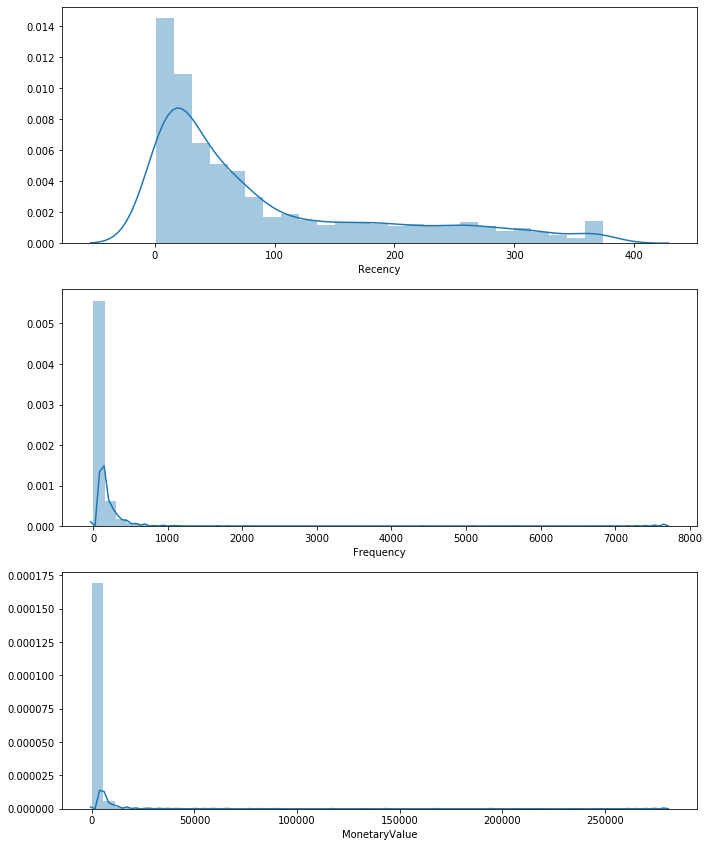

In [19]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

Logarithmic transformation is necessary to deal with skewness.

In [20]:
# Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

In [21]:
# Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)

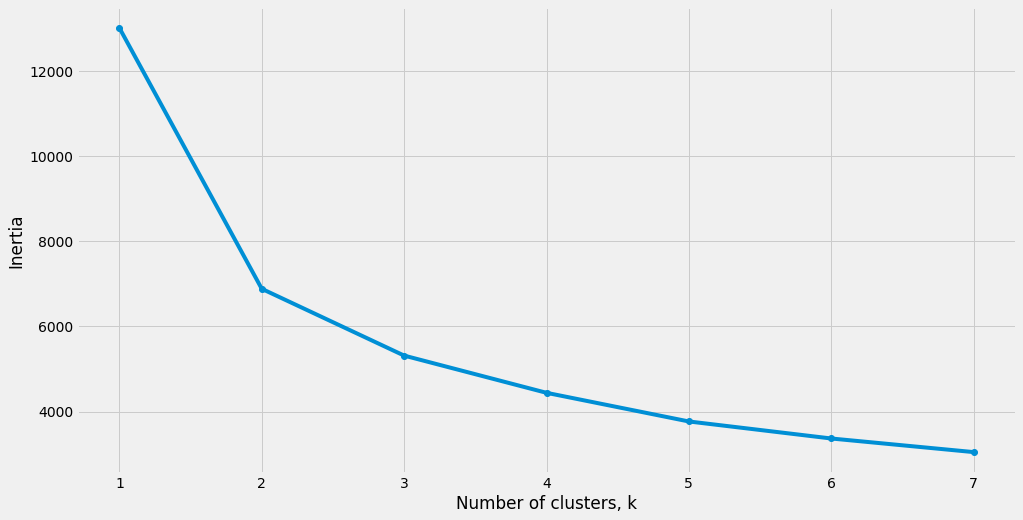

In [22]:
from sklearn.cluster import KMeans

# Get the Best cluster 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)
    
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.show()

Select cluster number 3

In [23]:
# clustering
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            13.0     260.0        6554.0   957
1            69.0      65.0        1167.0  1858
2           171.0      15.0         293.0  1523

In [24]:
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_rfm.index,columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized.reset_index(inplace = True)

rfm_melt = pd.melt(rfm_normalized,id_vars=['CustomerID','General_Segment','K_Cluster'],value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Sliver,1,Recency,1.409982
1,12347.0,Gold,0,Recency,-2.146578
2,12348.0,Sliver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,2,Recency,1.375072


# Visualize cluster with Heatmap

In [26]:
# For K-means cluster
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,-0.86,1.87,2.20
1,-0.25,-0.28,-0.43
2,0.85,-0.84,-0.86


In [27]:
# For RFM Score cluster
total_avg = rfm.iloc[:, 0:3].mean()
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Sliver,-0.22,-0.45,-0.48


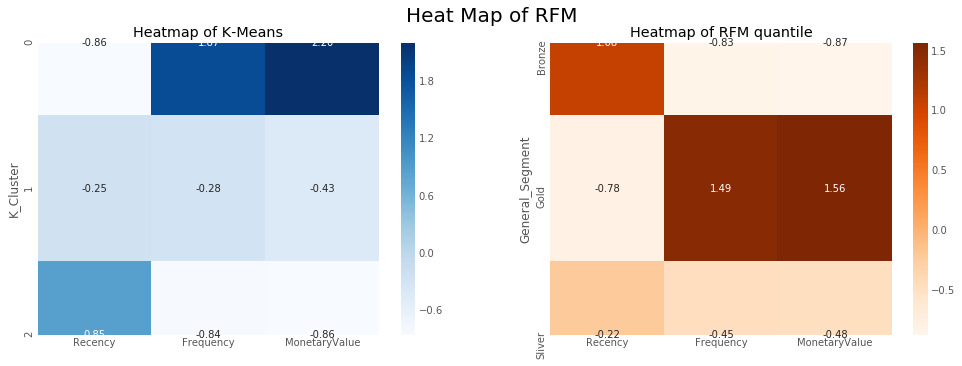

In [28]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()